In [1]:
from salishsea_tools import grid_tools, nc_tools, timeseries_tools, viz_tools
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec, patches, dates
from dateutil import parser
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import netCDF4 as nc

%matplotlib inline

In [117]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
f0 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/21sep14/SalishSea_1h_20140921_20140927_ptrc_T.nc')
f1 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/15oct14/SalishSea_1h_20141015_20141025_ptrc_T.nc')
f2 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/03dec14/SalishSea_1h_20141203_20141211_ptrc_T.nc')
f3 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/29jun15/SalishSea_1h_20150629_20150706_ptrc_T.nc')
f4 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/13jul15/SalishSea_1h_20150713_20150722_ptrc_T.nc')
f5 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/27aug15/SalishSea_1h_20150827_20150903_ptrc_T.nc')
f6 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/24jul16/SalishSea_1h_20160724_20160802_ptrc_T.nc')
f7 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/02aug16/SalishSea_1h_20160802_20160828_ptrc_T.nc')
f8 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/03apr17/SalishSea_1h_20170403_20170407_ptrc_T.nc')
f9 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/10jun17/SalishSea_1h_20170610_20170616_ptrc_T.nc')
f10 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/23jul17/SalishSea_1h_20170723_20170728_ptrc_T.nc')
f11 = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs/12sep17/SalishSea_1h_20170912_20170916_ptrc_T.nc')

In [4]:
f0surface = f0.variables['mytracer3'][:,0,:,:]
f1surface = f1.variables['mytracer3'][:,0,...]
f2surface = f2.variables['mytracer3'][:,0,...]
f3surface = f3.variables['mytracer3'][:,0,...]
f4surface = f4.variables['mytracer3'][:,0,...]
f5surface = f5.variables['mytracer3'][:,0,...]
f6surface = f6.variables['mytracer3'][:,0,...]
f7surface = f7.variables['mytracer3'][:,0,...]
f8surface = f8.variables['mytracer3'][:,0,...]
f9surface = f9.variables['mytracer3'][:,0,...]
f10surface = f10.variables['mytracer3'][:,0,...]
f11surface = f11.variables['mytracer3'][:,0,...]

In [5]:
f9surface.shape

(168, 898, 398)

In [6]:
together = np.append(f0surface, f1surface, axis = 0)
for f in ([f2surface,f3surface,f4surface,f5surface,f6surface,f7surface,f8surface,
           f9surface,f10surface,f11surface]):
    together = np.append(together, f, axis = 0)
f.shape

(120, 898, 398)

In [7]:
together.shape

(2712, 898, 398)

In [8]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [9]:
reshaped_f = np.ma.reshape(np.ma.masked_array(together, 
                                              mask = (1-mesh.variables['tmask'][:,0,...])
                                              *np.ones((2712,1,1))), ((2712, -1)))

In [10]:
Z = np.reshape(reshaped_f.compressed(), ((2712, -1)))
A_primeb, sqrtLb, E_Tb = np.linalg.svd(Z - Z.mean(axis=0)[np.newaxis, :], 
                                    full_matrices=False)
Ab = A_primeb.dot(np.diag(sqrtLb))
PercentVarb = sqrtLb**2/(sqrtLb**2).sum()
Z_0b = Ab[:, 0, np.newaxis].dot(E_Tb[0, np.newaxis, :])
Z_1b = Ab[:, 1, np.newaxis].dot(E_Tb[1, np.newaxis, :])

84.0
300.0
540.0
744.0
960.0
1176.0
1392.0
1836.0
2220.0
2364.0
2520.0
2652.0


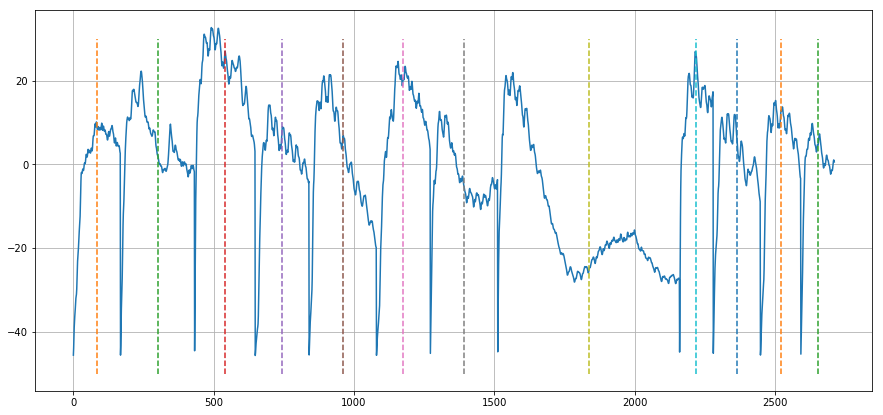

In [11]:
fig, ax = plt.subplots(figsize = ((15,7)))
ax.plot(Ab[:,0].T)
ax.grid('on')
n = 0
for f in ([f0surface, f1surface, f2surface, f3surface, f4surface, f5surface, 
           f6surface, f7surface, f8surface, f9surface, f10surface, f11surface]):
    j = f.shape[0]/2
    ax.plot((j+n, j+n), (-50,30), '--')
    print(j+n)
    n = n + f.shape[0]        

In [12]:
from salishsea_tools import timeseries_tools, geo_tools, tidetools

In [13]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')

In [14]:
bathy, X, Y = tidetools.get_bathy_data(grid)

In [15]:
lats = grid.variables['nav_lat'][:]
lons = grid.variables['nav_lon'][:]

compressed_lats0 = np.ma.masked_array(lats, 
                                     mask = 1 - 
                                      mesh.variables['tmask'][0,0,...]).compressed()
compressed_lons0 = np.ma.masked_array(lons, 
                                     mask = 1 
                                      - mesh.variables['tmask'][0,0,...]).compressed()

In [16]:
Yinds = np.array([])
Xinds = np.array([])
for lon, lat in zip(compressed_lons0, compressed_lats0):
    Yind, Xind = geo_tools.find_closest_model_point(lon, lat, X,Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)

In [17]:
import cmocean

In [20]:
PercentVarb[0]

0.4422418

In [18]:
for n in [84,300,540,744,960,1176,1392,1836,2220,2364,2520,2652]:
    print(Z_0b[n,:].max(), Z_0b[n,:].min())

0.092359535 -0.014878162
0.02227008 -0.0035874788
0.27118152 -0.04368453
0.08791757 -0.0141626075
0.06470277 -0.010422944
0.20773636 -0.03346417
0.0086134765 -0.05347009
0.041771963 -0.25930884
0.25677288 -0.041363448
0.063548006 -0.0102369245
0.12326104 -0.019856075
0.046929296 -0.0075598224


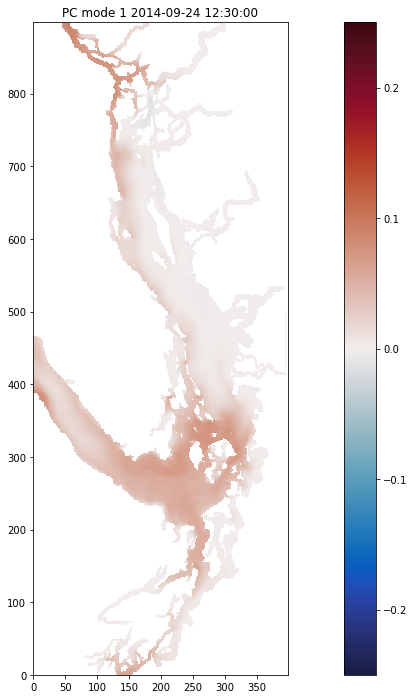

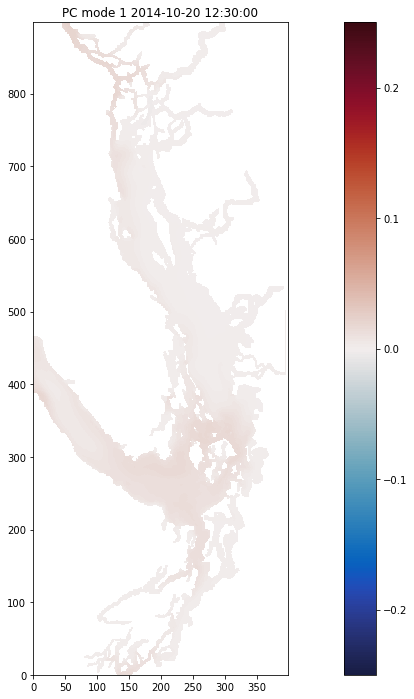

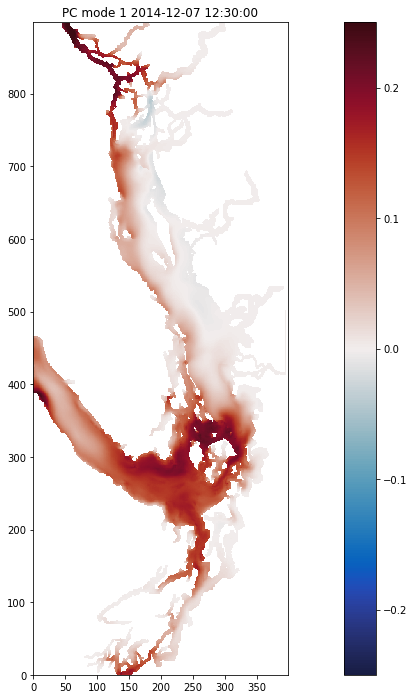

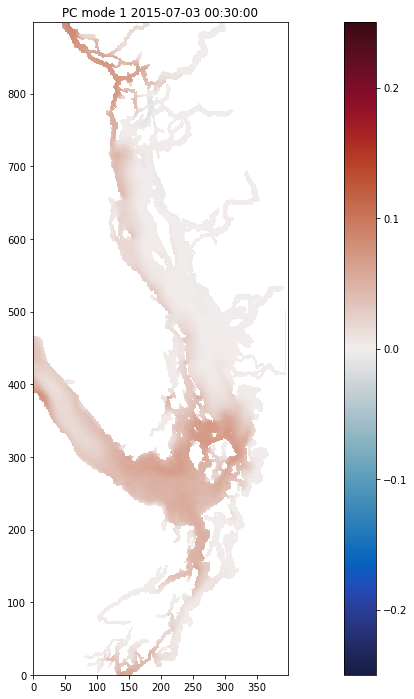

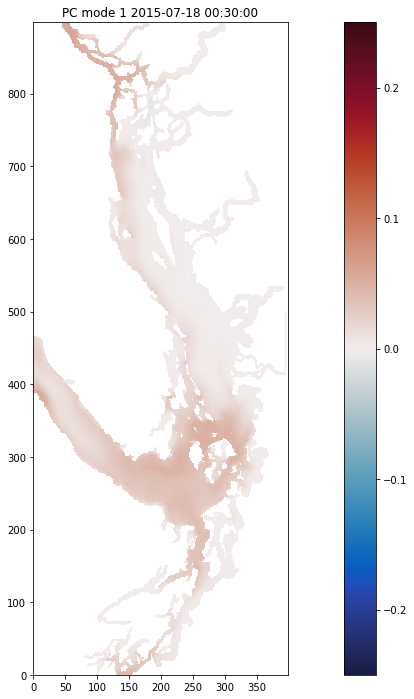

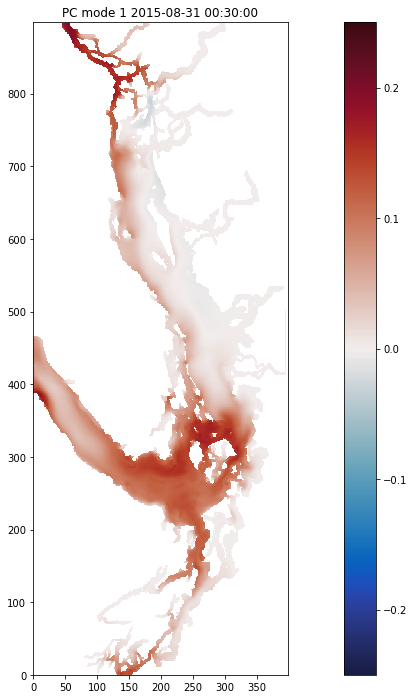

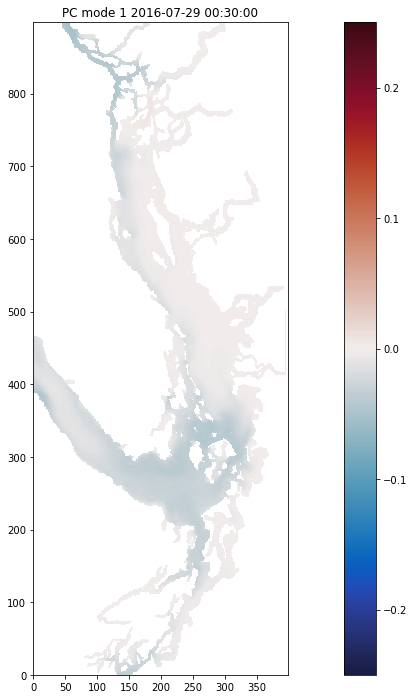

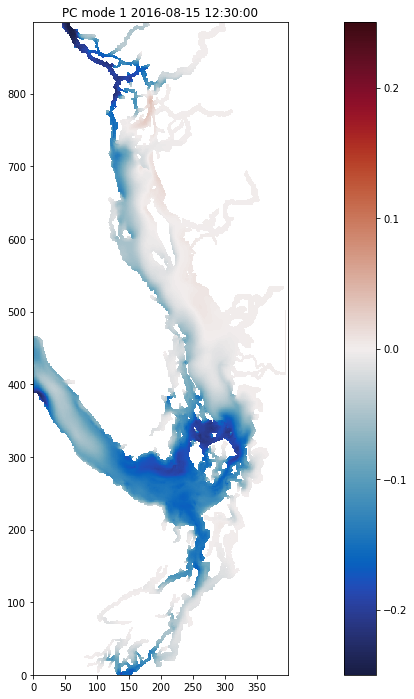

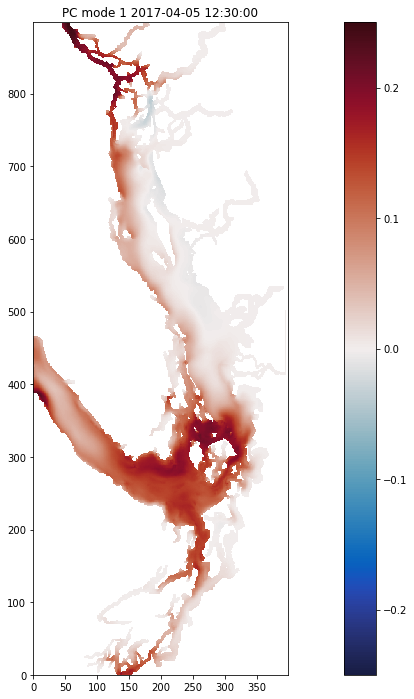

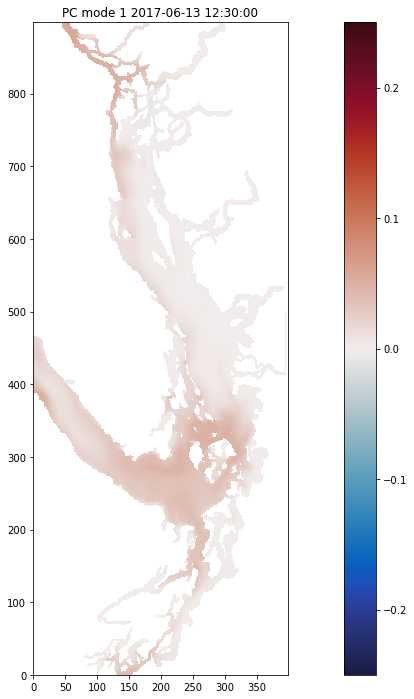

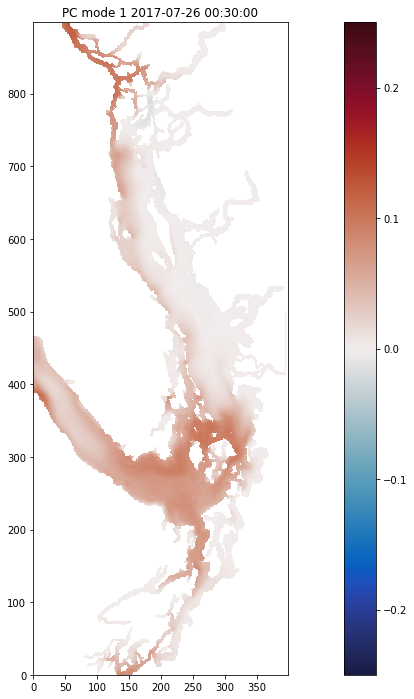

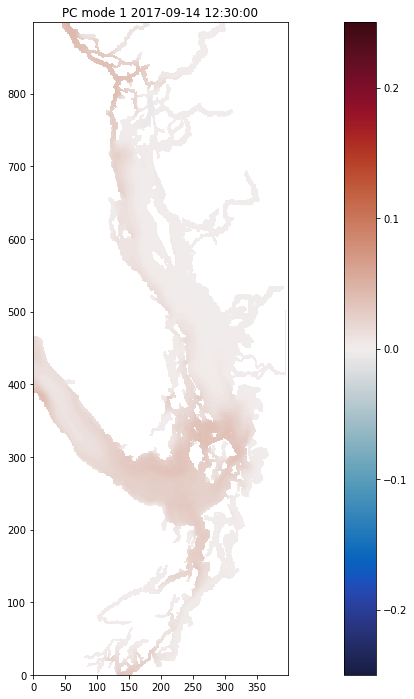

In [19]:
for n,p in zip([84,300,540,744,960,1176,1392,1836,2220,2364,2520,2652], 
               [f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11]):
    gridded = np.zeros((898,398))
    for Yind, Xind, data in zip(Yinds, Xinds, Z_0b[n,:]):
        gridded[int(Yind), int(Xind)] = data
    fig, ax = plt.subplots(figsize = ((20,12)))
    z = ax.pcolormesh(np.ma.masked_array(gridded, 
                                         mask = 1 - mesh.variables['tmask'][0,0,...]),
                      vmin = -0.25, vmax = 0.25, cmap = cmocean.cm.balance)
    fig.colorbar(z, ax=ax)
    middle = p.variables['time_counter'].shape[0]/2
    ax.set_title('PC mode 1 ' + str(nc.num2date(p.variables['time_counter'][middle], 
                                                p.variables['time_counter'].units)))
    viz_tools.set_aspect(ax);

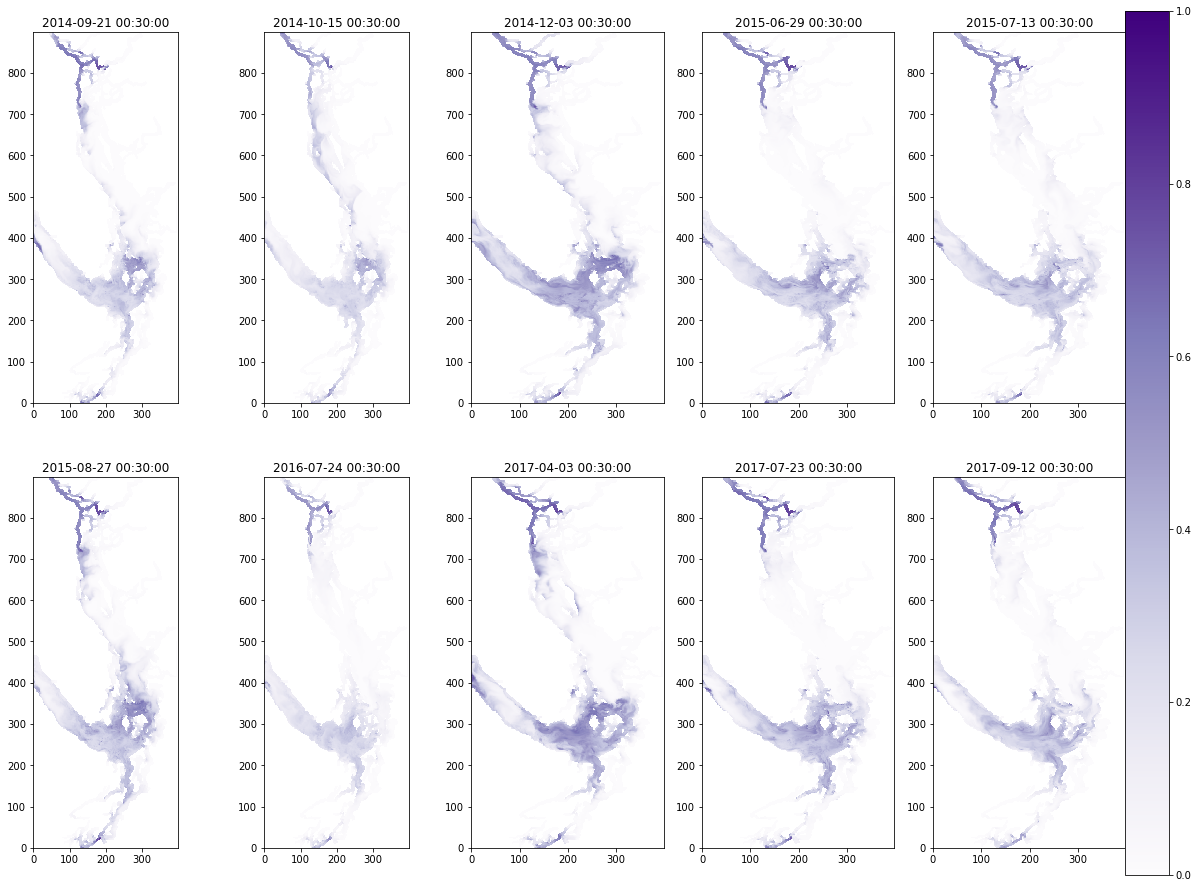

In [123]:
fig, ax = plt.subplots(2,5, figsize = (20,15))
ax[0,0].pcolormesh(np.ma.masked_array(f0surface[84,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[0,0].set_title(nc.num2date(f0.variables['time_counter'][0], 
                              f0.variables['time_counter'].units))
ax[0,1].pcolormesh(np.ma.masked_array(f1surface[132,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[0,1].set_title(nc.num2date(f1.variables['time_counter'][0], 
                              f1.variables['time_counter'].units))
ax[0,2].pcolormesh(np.ma.masked_array(f2surface[108,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[0,2].set_title(nc.num2date(f2.variables['time_counter'][0], 
                              f2.variables['time_counter'].units))
ax[0,3].pcolormesh(np.ma.masked_array(f3surface[96,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[0,3].set_title(nc.num2date(f3.variables['time_counter'][0], 
                              f3.variables['time_counter'].units))
ax[0,4].pcolormesh(np.ma.masked_array(f4surface[120,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[0,4].set_title(nc.num2date(f4.variables['time_counter'][0], 
                              f4.variables['time_counter'].units))
ax[1,0].pcolormesh(np.ma.masked_array(f5surface[96,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[1,0].set_title(nc.num2date(f5.variables['time_counter'][0], 
                              f5.variables['time_counter'].units))
ax[1,1].pcolormesh(np.ma.masked_array(f6surface[120,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[1,1].set_title(nc.num2date(f6.variables['time_counter'][0], 
                              f6.variables['time_counter'].units))
ax[1,2].pcolormesh(np.ma.masked_array(f7surface[60,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[1,2].set_title(nc.num2date(f7.variables['time_counter'][0], 
                              f7.variables['time_counter'].units))
ax[1,3].pcolormesh(np.ma.masked_array(f8surface[72,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[1,3].set_title(nc.num2date(f8.variables['time_counter'][0], 
                              f8.variables['time_counter'].units))
trc = ax[1,4].pcolormesh(np.ma.masked_array(f9surface[60,...], 
                                      mask = 1 - mesh.variables['tmask'][0,0,...]),
                   vmin = 0, vmax = 1, cmap = 'Purples')
ax[1,4].set_title(nc.num2date(f9.variables['time_counter'][0], 
                              f9.variables['time_counter'].units))
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(trc, cax=cax)

for ax0 in ax[:,0]:
    viz_tools.set_aspect(ax0)
for ax0 in ax[:,1]:
    viz_tools.set_aspect(ax0)

In [139]:
from salishsea_tools import timeseries_tools

In [149]:
Z_0b[0,np.newaxis,:].shape

(1, 84042)

In [144]:
Xinds.shape

(84042,)

In [142]:
Yinds.shape

(84042,)

In [173]:
timeseries_tools.reshape_to_grid(Z_0b[0, np.newaxis,:], [Yinds, Xinds], 
                                 (898,398))

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/timeseries_tools.py:242: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  data_grid[:, coord1, coord2] = data_xyz


array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])